In [69]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch

root_dir = 'img_align_celeba'
img_size = (128, 128)

# Define the transformation. You might want to transform the images (e.g., resizing, normalization) for your specific task.
transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    # transforms.Resize((128, 160)),
    transforms.ToTensor(), # Convert images to tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize images
])

dataset = ImageFolder(root_dir, transform=transform)

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

class AutoEncoder(nn.Module):
    """Abstract AutoEncoder class"""
    encoder: nn.Module
    decoder: nn.Module
    
    def get_latent_size(self, img_size=img_size, n_channels=3):
        """Return the latent dimension of the AutoEncoder given an input image size."""
        
        dummy = torch.zeros((n_channels,) + img_size).unsqueeze(0).to(device)
        return self.encoder(dummy).squeeze(0).shape
    
    
class SaliencyAutoEncoder(nn.Module):
    def __init__(self):
        super(SaliencyAutoEncoder, self).__init__()
        
        self.saliency_mapper = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # 64x64
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, stride=2, padding=1), # 8x8
        )
        
        self.high_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 8x8
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.low_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 8x8
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 4x4
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.k = 32
        
    def fold(self, patches):
        # Parameters for patches
        batch_size = patches.shape[0]
        channels = 3
        image_size = 128
        patch_size = 16
        stride = 16  # stride of 16 will ensure non-overlapping patches
        
        patches = patches.reshape((batch_size, channels, 8 * 8, patch_size * patch_size))

        # Permute to bring patches to the last but one dimension and flatten patches
        patches = patches.permute(0, 1, 3, 2).contiguous()
        patches = patches.view(batch_size, channels * patch_size * patch_size, 8 * 8)

        # Calculate output size
        output_height = 8 * patch_size
        output_width = 8 * patch_size

        # Fold to reconstruct the image
        return F.fold(patches, output_size=(output_height, output_width), kernel_size=(patch_size, patch_size), stride=stride)

    
    def forward(self, x):
        saliency = self.saliency_mapper(x) # Nx1x8x8
        saliency = torch.flatten(saliency, start_dim=1, end_dim=-1) # Nx64
                
        topk = torch.topk(saliency, self.k, dim=-1)
        fg_mask = torch.zeros_like(saliency, dtype=torch.bool, device=device)
        fg_mask[torch.arange(fg_mask.size(0)).unsqueeze(1), topk.indices] = True
        fg_mask = fg_mask.reshape((fg_mask.size(0), 8, 8))
        bg_mask = ~fg_mask
                
        # Parameters for patches
        image_size = 128
        patch_size = 16
        stride = 16  # stride of 16 will ensure non-overlapping patches

        # Extract patches
        # [batch_size, channels, patch_i, patch_j, patch_size, patch_size]
        patches = x.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
        patches = patches.permute((0, 2, 3, 1, 4, 5))
                
        fg = patches[fg_mask, ...] # [batch_size, k, C, P, P]
        bg = patches[bg_mask, ...]  # [batch_size, 64 - k, C, P, P]
                
        r_fg = self.high_res(fg) # TODO: PE
        r_bg = self.low_res(bg)
        
        r_patches = torch.zeros_like(patches, device=device)
        r_patches[fg_mask] = r_fg
        r_patches[bg_mask] = r_bg
        
        r_patches = r_patches.permute((0, 3, 1, 2, 4, 5))
        
        return self.fold(r_patches)
        
        # return reconstructed
    
    
class FCAutoEncoder(AutoEncoder):
    def __init__(self):
        super(FCAutoEncoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(49152, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 49152),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 128, 128))
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class CNNAutoencoder(AutoEncoder):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input channels = 3 (RGB), Output channels = 16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7) # No padding
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Using Sigmoid to ensure the output is between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
import os

models = {}

for file in sorted(os.listdir('./')):
    if file.endswith('.pt'):
        models[file] = torch.load(file).to('cpu')

In [72]:
import matplotlib.pyplot as plt

def show_all(img):
    plt.figure(figsize=(5 * len(models), 5)) 
    
    plt.subplot(1, len(models) + 1, 1)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    
    for i, filename in enumerate(models):
        reconstruction = models[filename](img.unsqueeze(0)).detach().squeeze(0)
    
        plt.subplot(1, len(models) + 1, i + 2)
        plt.imshow(torch.permute(reconstruction, (1, 2, 0)))
        plt.title(filename)
        
def show_all_batch(imgs):
    plt.figure(figsize=(5 * len(models), 5 * len(imgs))) 
    plt.tight_layout()

    for j, img in enumerate(imgs):        
        plt.subplot(len(imgs), len(models) + 1, j * (len(models) + 1) + 1)
        plt.imshow(torch.permute(img, (1, 2, 0)))
        
        for i, filename in enumerate(models):
            reconstruction = models[filename](img.unsqueeze(0)).detach().squeeze(0)
        
            plt.subplot(len(imgs), len(models) + 1, j * (len(models) + 1) + i + 2)
            plt.imshow(torch.permute(reconstruction, (1, 2, 0)))
            plt.title(filename)
            
            
def slice_dataset(s: int, e: int):
    return [dataset[i][0] for i in range(s, e)]

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

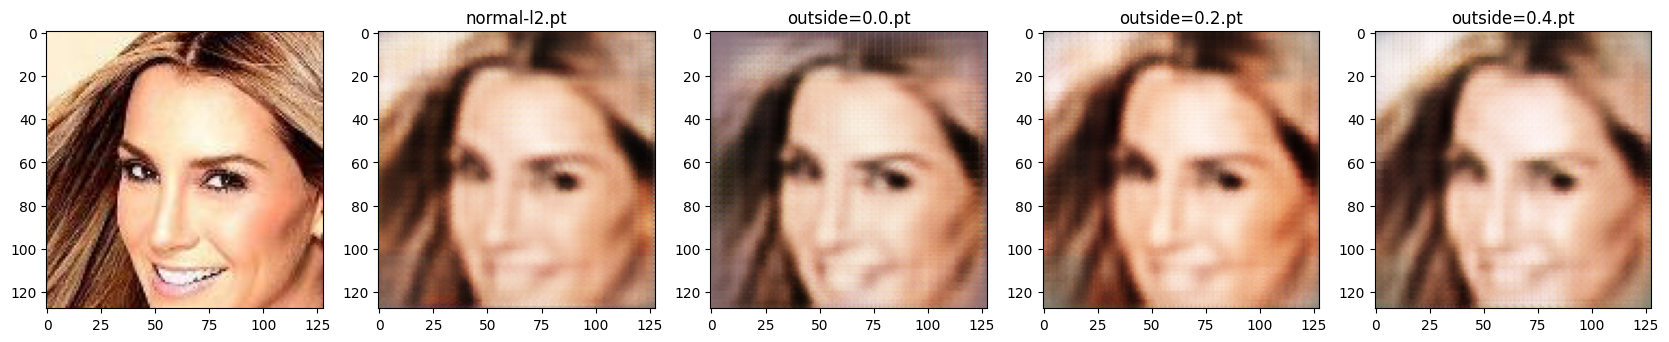

In [73]:
show_all_batch(slice_dataset(0, 5))

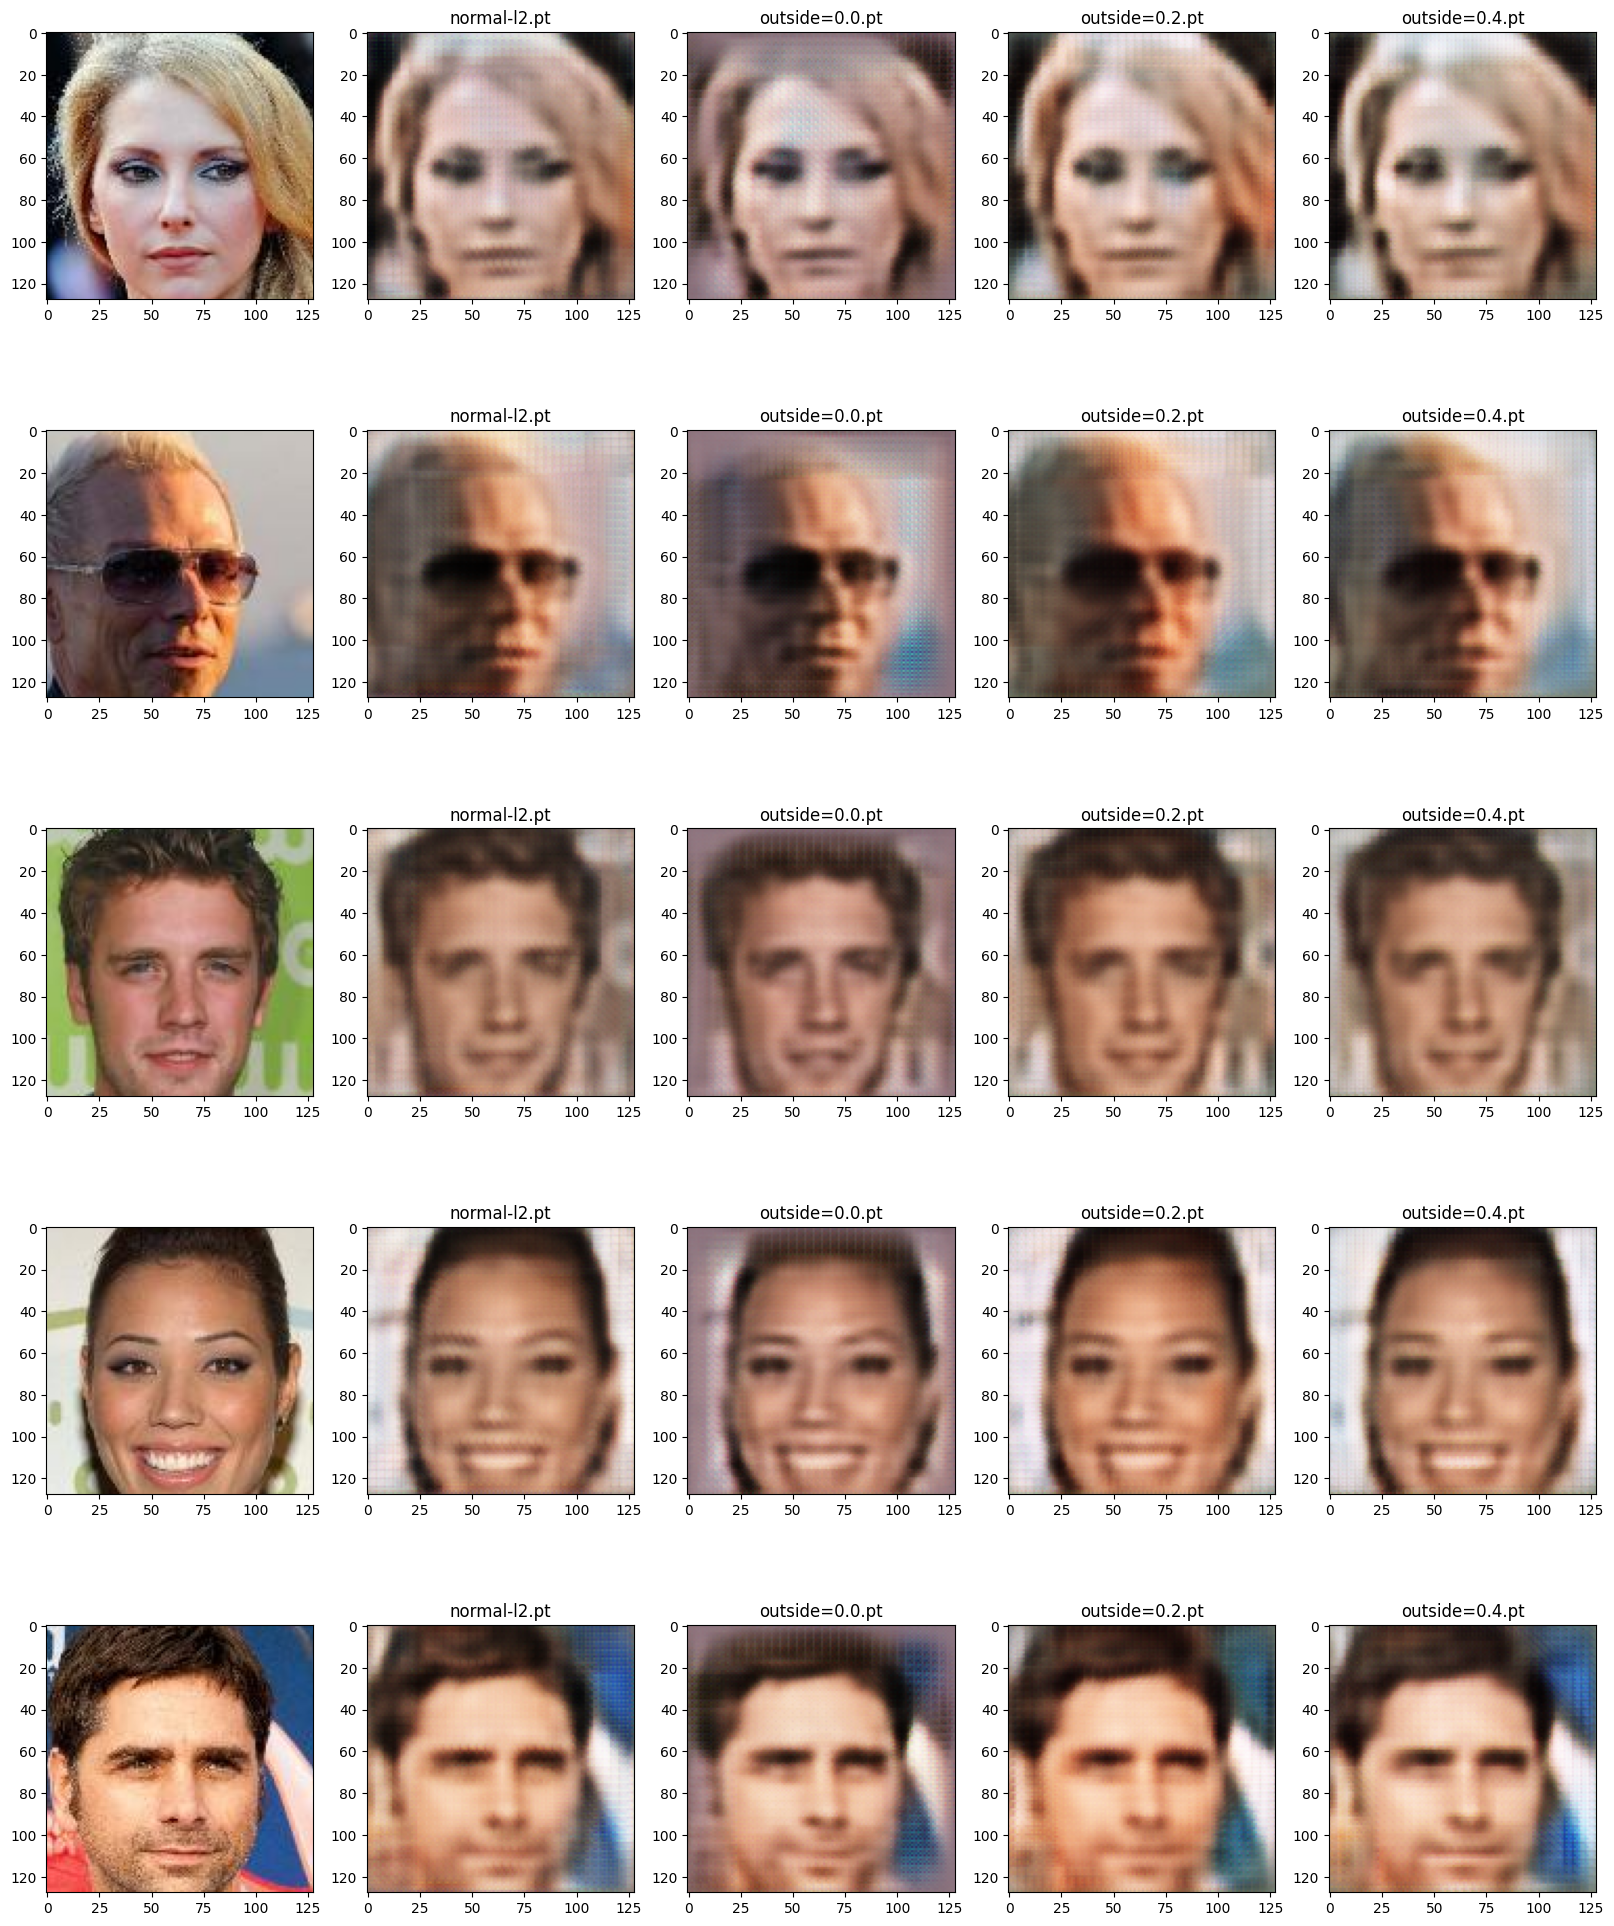

In [ ]:
show_all_batch(slice_dataset(200, 205))